In [2]:

import sys
import os

project_root = os.path.abspath(os.path.join(os.getcwd(), ".."))
if project_root not in sys.path:
    sys.path.append(project_root)

import matplotlib.pyplot as plt

import pandas as pd

from src.data_loading import load_price_data
from src.metrics import add_daily_returns
from src.sentiment import add_textblob_sentiment, aggregate_daily_sentiment
from src.news_stock_correlation import (
    align_daily_sentiment_and_returns,
    compute_sentiment_return_correlation,
)


In [3]:
# -----------------------------------------------
# LOAD THE RAW NEWS DATASET
# -----------------------------------------------

# Path to Task 1 news dataset
news_path = "../data/raw_analyst_ratings.csv"

# Read the CSV using pandas
news_df = pd.read_csv(news_path)

# Show first few rows
news_df.head()


,Unnamed: 0,headline,url,publisher,date,stock
0,0,Stocks That Hit 52-Week Highs On Friday,https://www.benzinga.com/news/20/06/16190091/s...,Benzinga Insights,2020-06-05 10:30:54-04:00,A
1,1,Stocks That Hit 52-Week Highs On Wednesday,https://www.benzinga.com/news/20/06/16170189/s...,Benzinga Insights,2020-06-03 10:45:20-04:00,A
2,2,71 Biggest Movers From Friday,https://www.benzinga.com/news/20/05/16103463/7...,Lisa Levin,2020-05-26 04:30:07-04:00,A
3,3,46 Stocks Moving In Friday's Mid-Day Session,https://www.benzinga.com/news/20/05/16095921/4...,Lisa Levin,2020-05-22 12:45:06-04:00,A
4,4,B of A Securities Maintains Neutral on Agilent...,https://www.benzinga.com/news/20/05/16095304/b...,Vick Meyer,2020-05-22 11:38:59-04:00,A


In [4]:
# -----------------------------------------------
# FILTER NEWS TO JUST NVDA (the stock we're studying)
# -----------------------------------------------

# Convert the 'date' column to actual datetime format
news_df["date"] = pd.to_datetime(news_df["date"], errors="coerce")

# Keep only the rows where the "stock" column equals "NVDA"
nvda_news = news_df[news_df["stock"] == "NVDA"]

# Remove rows missing headline or date
nvda_news = nvda_news.dropna(subset=["headline", "date"])

# Show sample rows
nvda_news.head()


,Unnamed: 0,headline,url,publisher,date,stock
924271,929039,Shares of several technology companies are tra...,https://www.benzinga.com/wiim/20/06/16224173/s...,Benzinga Newsdesk,2020-06-10 12:37:10-04:00,NVDA
924272,929040,Afternoon Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/1622357...,Benzinga Insights,2020-06-10 12:12:25-04:00,NVDA
924273,929041,Morning Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/1622174...,Benzinga Insights,2020-06-10 10:22:11-04:00,NVDA
924274,929042,Shares of several technology companies are tra...,https://www.benzinga.com/wiim/20/06/16214789/s...,Benzinga Newsdesk,2020-06-09 13:40:43-04:00,NVDA
924275,929043,Afternoon Market Stats in 5 Minutes,https://www.benzinga.com/markets/20/06/1620319...,Benzinga Insights,2020-06-08 12:30:29-04:00,NVDA


In [5]:
# -----------------------------------------------
# ADD SENTIMENT SCORE TO EACH HEADLINE
# -----------------------------------------------

# Apply TextBlob sentiment to each NVDA headline
# This adds two columns: sentiment_polarity, sentiment_subjectivity
nvda_news_sent = add_textblob_sentiment(nvda_news, text_col="headline")

# Show headline with sentiment score
nvda_news_sent[["headline", "sentiment_polarity"]].head()


,headline,sentiment_polarity
924271,Shares of several technology companies are tra...,0.08125
924272,Afternoon Market Stats in 5 Minutes,0.00000
924273,Morning Market Stats in 5 Minutes,0.00000
924274,Shares of several technology companies are tra...,0.26250
924275,Afternoon Market Stats in 5 Minutes,0.00000


In [6]:
# -----------------------------------------------
# AGGREGATE SENTIMENT PER DAY
# -----------------------------------------------

# Convert headline-level sentiment into daily sentiment
# Example output: date_only, avg_sentiment, headline_count
daily_sentiment = aggregate_daily_sentiment(
    nvda_news_sent,
    date_col="date",
    sentiment_col="sentiment_polarity",
)

# Show the daily sentiment table
daily_sentiment.head()


,date_only,avg_sentiment,headline_count
0,2020-05-31,0.000000,1
1,2020-06-02,0.250000,2
2,2020-06-08,0.000000,3
3,2020-06-09,0.262500,1
4,2020-06-10,0.027083,3


In [8]:
# -----------------------------------------------
# LOAD NVDA PRICE DATA + COMPUTE DAILY RETURNS
# -----------------------------------------------

# Load NVDA daily prices from your data folder
price_df = load_price_data("../data/NVDA.csv")

# Compute daily percentage change in stock price
price_df = add_daily_returns(price_df)

# Show Date, Close, and daily_change
price_df[["Date", "Close", "daily_return"]].head()


d:\KAIM\weak-1\Predicting-Price-Moves-with-News-Sentiment\src\data_loading.py:75: FutureWarning: The argument 'date_parser' is deprecated and will be removed in a future version. Please use 'date_format' instead, or read your data in as 'object' dtype and then call 'to_datetime'.
  df = pd.read_csv(


,Date,Close,daily_return
0,2009-01-02,0.199652,NaN
1,2009-01-05,0.203319,0.018370
2,2009-01-06,0.210196,0.033822
3,2009-01-07,0.197589,-0.059978
4,2009-01-08,0.192546,-0.025522


In [9]:
# -----------------------------------------------
# MERGE DAILY SENTIMENT & DAILY RETURNS BY DATE
# -----------------------------------------------

# Align both datasets based on date_only
aligned_df = align_daily_sentiment_and_returns(
    daily_sentiment,
    price_df,
    sentiment_date_col="date_only",
    returns_date_col="Date",
)

# Show the merged dataset
aligned_df.head()


,date_only,avg_sentiment,headline_count,daily_return
0,2020-06-02,0.250000,2,0.002157
1,2020-06-08,0.000000,3,-0.012892
2,2020-06-09,0.262500,1,0.027370
3,2020-06-10,0.027083,3,0.035458


In [10]:
# -----------------------------------------------
# CALCULATE PEARSON CORRELATION
# -----------------------------------------------

corr = compute_sentiment_return_correlation(
    aligned_df,
    sentiment_col="avg_sentiment",
    return_col="daily_return",
)

corr


np.float64(0.1756993073366674)

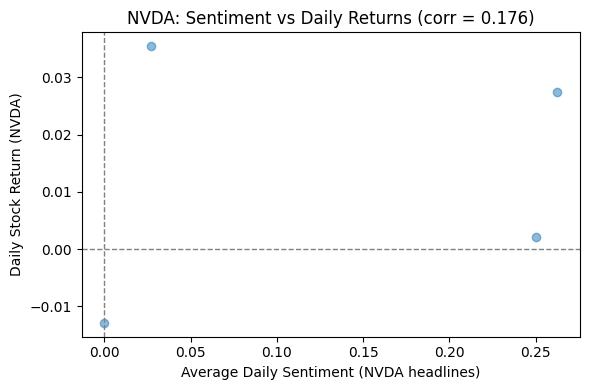

In [11]:
# -----------------------------------------------
# SCATTER PLOT OF SENTIMENT VS RETURNS
# -----------------------------------------------

plt.figure(figsize=(6, 4))

plt.scatter(
    aligned_df["avg_sentiment"],
    aligned_df["daily_return"],
    alpha=0.5
)

plt.xlabel("Average Daily Sentiment (NVDA headlines)")
plt.ylabel("Daily Stock Return (NVDA)")
plt.title(f"NVDA: Sentiment vs Daily Returns (corr = {corr:.3f})")

# Add vertical and horizontal lines at zero for reference
plt.axhline(0, color="grey", linestyle="--", linewidth=1)
plt.axvline(0, color="grey", linestyle="--", linewidth=1)

plt.tight_layout()
plt.show()


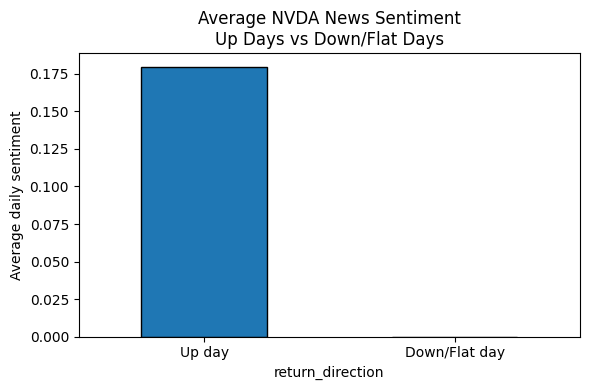

In [13]:
# Average sentiment on up days vs down days

# Create a column marking up vs down days
aligned_df["return_direction"] = aligned_df["daily_return"].apply(
    lambda x: "Up day" if x > 0 else "Down/Flat day"
)

avg_sent_by_dir = (
    aligned_df.groupby("return_direction")["avg_sentiment"]
    .mean()
    .reindex(["Up day", "Down/Flat day"])
)

plt.figure(figsize=(6, 4))
avg_sent_by_dir.plot(kind="bar", edgecolor="black")
plt.title("Average NVDA News Sentiment\nUp Days vs Down/Flat Days")
plt.ylabel("Average daily sentiment")
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()
